<a href="https://colab.research.google.com/github/Poojithavb/CMPE258-Project/blob/master/TopicModelling/TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Installations
import sys
if 'google.colab' in sys.modules:
    !pip install pandas-profiling==2.*
    !python -m spacy download en_core_web_lg
    !pip install pyldavis
    !pip install gensim
    !pip install --upgrade autopep8

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
Requirement already up-to-date: autopep8 in /usr/local/lib/python3.6/dist-packages (1.5.4)


In [5]:
import json
import requests
import pandas as pd
import numpy as np
import re
from collections import Counter

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'  

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#tokenizing
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Data Preprocessing

In [8]:
covid_data = pd.read_csv('/content/drive/My Drive/256 project/preprocessed_data.csv')

In [9]:
covid_data

,created_at,tweet_id,text,iso_language_code,result_type,source,user_id,user_name,user_location,users_followers_count,statuses_count,retweeted_text,retweet_count,hashtags,favorite_count,retweeted_status,url,clean_text
0,2020-07-10 05:49:12,1281465476191621122,How Can Accounting Software Reduce the Impact ...,en,recent,Twitter Web App,742999699272040449,📚RayvatAccounting.com,United States,1773,9613,How Can Accounting Software Reduce the Impact ...,0,Coronavirus,0,This is a retweet,This is a retweet,accounting software reduce impact coronavirus ...
1,2020-07-10 05:49:29,1281465544798085131,What people know and how they behave during CO...,en,recent,News Medical,39211040,News Medical,None,13293,54866,What people know and how they behave during CO...,0,Canada,1,This is a retweet,This is a retweet,people know behave covid19 canadian perspectiv...
2,2020-07-10 05:58:18,1281467763890860032,RT @Poorvika_Mobile: A silver lining amidst th...,en,recent,Twitter for Android,1250719740701491200,Subi,None,2,317,RT @Poorvika_Mobile: A silver lining amidst th...,932,"Poorvika_Mobiles, India",0,This is a retweet,This is a retweet,silver lining amidst chaoswe poorvikamobiles t...
3,2020-07-10 05:58:56,1281467923899580417,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,en,recent,Twitter for Android,1242200819308662784,Gurbet,None,623,2722,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,157,COVID19,0,This is a retweet,This is a retweet,harun cumen balikesir prison couldnt see kids ...
4,2020-07-10 06:00:00,1281468192125263873,Oximeters won't steal your fingerprints. Turni...,en,recent,TweetDeck,3780315496,International Fact-Checking Network,🌎 🌍 🌏,27111,11456,Oximeters won't steal your fingerprints. Turni...,6,None,6,This is a retweet,This is a retweet,oximeters wont steal fingerprints turning tech...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,2020-08-04 05:35:53,1290521819062165504,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,Twitter for addempsea,1196874000837816320,quotesBot,None,907,136081,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...
29141,2020-08-04 05:35:58,1290521841157713920,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,nlognrobot,1260062769543434240,#100DaysOfCode,None,1435,187553,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...
29142,2020-08-04 05:36:34,1290521991599009792,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,TheDataScienceBot,1276058041389953024,The Data Science Bot,None,588,57258,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...
29143,2020-08-04 05:37:44,1290522287389605889,Wow! Spain &amp; France don’t have any new dai...,en,recent,Twitter for iPhone,3242523302,Stray Turtle,"California, USA",74,60615,Wow! Spain &amp; France don’t have any new dai...,0,None,0,This is a retweet,This is a retweet,wow spain amp france dont new daily cases that...


##Tokenization

In [10]:
word_tokens = []
for sent in covid_data['clean_text'].astype(str):
    print(word_tokenize(sent))
    word_tokens.append(word_tokenize(sent))

Streaming output truncated to the last 5000 lines.
['texas', 'coronavirus', 'numbers', 'showing', 'improvement', 'read', 'cdc', 'coronavirus', 'covid19']
['mask', 'pay', 'fine', 'bay', 'area', 'starts', 'moving', 'enforce', 'coronavirus', 'rules', 'read', 'cdc']
['sinclair', 'pulls', 'controversial', 'show', 'coronavirus', 'read', 'cdc', 'coronavirus']
['americas', 'next', 'housing', 'crisis', 'pandemic', 'pushing', 'renters', 'brink', 'covid19', 'coronavirus', 'pandemichttps']
['relatives', 'sarscov2', 'may', 'pose', 'health', 'threat', 'years', 'come', 'cold', 'commoncold']
['americas', 'next', 'housing', 'crisis', 'pandemic', 'pushing', 'renters', 'brink', 'covid19', 'coronavirus', 'pandemichttps']
['volunteer', 'doctors', 'spain', 'portugalargentina', 'costa', 'rica', 'members', 'samu', 'foundation', 'arrive', 'oscar', 'arnul']
['coronavirus', 'ravaging', 'entire', 'south', 'texas', 'families', 'medical', 'teams', 'covid19', 'covid', 'coronavirus', 'trump', 'biden', 'pand']
['every

In [11]:
covid_data['tokenized_text'] = word_tokens

##Lemmatization

In [12]:
# Make tokens a string again
covid_data['tokens_back_to_text'] = [' '.join(map(str, l)) for l in covid_data['tokenized_text']]


In [13]:
def get_lemmas(text):
    lemmas=[]
    doc = nlp(text)


    for token in doc:
        if((token.is_stop == False) and (token.is_punct==False)) and (token.pos_!='PRON'):
            lemmas.append(token.lemma_)
    return lemmas

covid_data['lemmas_tokens'] = covid_data['tokens_back_to_text'].apply(get_lemmas)

In [14]:
# Make lemmas a string again
covid_data['lemmas_back_to_text'] = [' '.join(map(str, lt)) for lt in covid_data['lemmas_tokens']]

In [15]:
covid_data

,created_at,tweet_id,text,iso_language_code,result_type,source,user_id,user_name,user_location,users_followers_count,statuses_count,retweeted_text,retweet_count,hashtags,favorite_count,retweeted_status,url,clean_text,tokenized_text,tokens_back_to_text,lemmas_tokens,lemmas_back_to_text
0,2020-07-10 05:49:12,1281465476191621122,How Can Accounting Software Reduce the Impact ...,en,recent,Twitter Web App,742999699272040449,📚RayvatAccounting.com,United States,1773,9613,How Can Accounting Software Reduce the Impact ...,0,Coronavirus,0,This is a retweet,This is a retweet,accounting software reduce impact coronavirus ...,"[accounting, software, reduce, impact, coronav...",accounting software reduce impact coronavirus ...,"[accounting, software, reduce, impact, coronav...",accounting software reduce impact coronavirus ...
1,2020-07-10 05:49:29,1281465544798085131,What people know and how they behave during CO...,en,recent,News Medical,39211040,News Medical,None,13293,54866,What people know and how they behave during CO...,0,Canada,1,This is a retweet,This is a retweet,people know behave covid19 canadian perspectiv...,"[people, know, behave, covid19, canadian, pers...",people know behave covid19 canadian perspectiv...,"[people, know, behave, covid19, canadian, pers...",people know behave covid19 canadian perspectiv...
2,2020-07-10 05:58:18,1281467763890860032,RT @Poorvika_Mobile: A silver lining amidst th...,en,recent,Twitter for Android,1250719740701491200,Subi,None,2,317,RT @Poorvika_Mobile: A silver lining amidst th...,932,"Poorvika_Mobiles, India",0,This is a retweet,This is a retweet,silver lining amidst chaoswe poorvikamobiles t...,"[silver, lining, amidst, chaoswe, poorvikamobi...",silver lining amidst chaoswe poorvikamobiles t...,"[silver, line, amidst, chaoswe, poorvikamobile...",silver line amidst chaoswe poorvikamobiles tha...
3,2020-07-10 05:58:56,1281467923899580417,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,en,recent,Twitter for Android,1242200819308662784,Gurbet,None,623,2722,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,157,COVID19,0,This is a retweet,This is a retweet,harun cumen balikesir prison couldnt see kids ...,"[harun, cumen, balikesir, prison, couldnt, see...",harun cumen balikesir prison couldnt see kids ...,"[harun, cumen, balikesir, prison, not, kid, mo...",harun cumen balikesir prison not kid month amp...
4,2020-07-10 06:00:00,1281468192125263873,Oximeters won't steal your fingerprints. Turni...,en,recent,TweetDeck,3780315496,International Fact-Checking Network,🌎 🌍 🌏,27111,11456,Oximeters won't steal your fingerprints. Turni...,6,None,6,This is a retweet,This is a retweet,oximeters wont steal fingerprints turning tech...,"[oximeters, wont, steal, fingerprints, turning...",oximeters wont steal fingerprints turning tech...,"[oximeter, will, not, steal, fingerprint, turn...",oximeter will not steal fingerprint turn techn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,2020-08-04 05:35:53,1290521819062165504,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,Twitter for addempsea,1196874000837816320,quotesBot,None,907,136081,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...,"[emerging, technologies, tracking, covid19, pa...",emerging technologies tracking covid19 pandemi...,"[emerge, technology, track, covid19, pandemic,...",emerge technology track covid19 pandemic bigda...
29141,2020-08-04 05:35:58,1290521841157713920,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,nlognrobot,1260062769543434240,#100DaysOfCode,None,1435,187553,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...,"[emerging, technologies, tracking, covid19, pa...",emerging technologie

#Base Model

In [16]:
#Create a id2word dictionary
id2word = Dictionary(covid_data['lemmas_tokens'])
print(len(id2word))

20652


In [17]:
#Filtering Extremes
id2word.filter_extremes(no_below=2,no_above=0.99)
print(len(id2word))

11801


In [18]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in covid_data['lemmas_tokens']]

In [27]:
#Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus,num_topics=5,id2word=id2word,workers=12,passes=5)

In [29]:
#Filtering for words
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [30]:
#create topics
topics = [' '.join(t[0:10])for t in words]

In [31]:
#Getting the topics
for id,t in enumerate(topics):
    print(f"------Topic {id} -----")
    print(t,end="\n\n")

------Topic 0 -----
pandemic covid19 coronavirus care deadly midst himselfvote death new read

------Topic 1 -----
covid19 pandemic coronavirus school mask new reopen amid covid people

------Topic 2 -----
covid19 coronavirus pandemic trump covid biden read say mask not

------Topic 3 -----
coronavirus pandemic covid19 case corona vaccine amp thank covid mask

------Topic 4 -----
coronavirus covid19 case pandemic new read death update report cdc



In [32]:
#compute perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity:', base_perplexity)

#compute coherence score
coherence_model = CoherenceModel(model=base_model,texts = covid_data['lemmas_tokens'],dictionary=id2word,coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score:',coherence_lda_model_base)


Perplexity: -7.344915022345954

Coherence Score: 0.23944299392157675


In [33]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.015492  0.145864       1        1  27.443918
2     -0.062460 -0.001786       2        1  23.871769
3     -0.051928  0.031565       3        1  19.997190
1     -0.069685 -0.144251       4        1  16.576096
0      0.199565 -0.031392       5        1  12.111029, topic_info=                  Term         Freq        Total Category  logprob  loglift
603              trump  1877.000000  1877.000000  Default  30.0000  30.0000
59            pandemic  8905.000000  8905.000000  Default  29.0000  29.0000
1369              care   597.000000   597.000000  Default  28.0000  28.0000
965              biden   777.000000   777.000000  Default  27.0000  27.0000
72              school   922.000000   922.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
921              datum   102.552765   277.022095   Topic5  -5.7729   1.1173
175             report   119.235329  1147.950806   Topic5  -5.6221  -0.1536
63                home   105.948814   388.077026   Topic5  -5.7403   0.8128
1138  coronavirusindia   111.030296   756.864319   Topic5  -5.6934   0.1917
32                 not   104.574600  1010.873047   Topic5  -5.7533  -0.1576

[402 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
1710       3  0.972124           0000
1710       4  0.015189           0000
11442      1  0.017094  100daysofcode
11442      2  0.017094  100daysofcode
11442      4  0.017094  100daysofcode
...      ...       ...            ...
346        4  0.060248          world
346        5  0.061754          world
4657       2  0.021769         xprize
4657       4  0.957849         xprize
4657       5  0.021769         xprize

[1031 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

#LDA model

In [34]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(covid_data['lemmas_back_to_text'])

In [36]:
#Search Param
params = {'n_components':[10,15,20,25,30],'learning_decay':[.5,.7,.9]}

#initialize the model
lda = LatentDirichletAllocation()

model = GridSearchCV(lda,param_grid=params)

model.fit(data_vectorized)
GridSearchCV(cv=None,error_score='raise',estimator=LatentDirichletAllocation(batch_size=128,doc_topic_prior=None,evaluate_every=1,learning_decay=0.7,
                                                  learning_method=None, learning_offset=10.0,
                                                  max_doc_update_iter=100,max_iter=10,
                                                   mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)
                                                

GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [37]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -562059.4014248778
Model Perplexity:  1650.750027438906


In [38]:
#optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_topics = []
    model_topic_list = []
    for num_topics in range(start,limit,step):
        model = LdaMulticore(corpus=corpus,num_topics = num_topics,id2word=id2word)
        model_topic_list.append(model)
        coherencemodel = CoherenceModel(model = model,texts=texts,dictionary =dictionary,coherence='c_v')
        coherence_values_topics.append(coherencemodel.get_coherence())
    return model_topic_list, coherence_values_topics

In [39]:
model_topic_list, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=covid_data['lemmas_tokens'],
                                                        start=2, limit=200, step=6)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


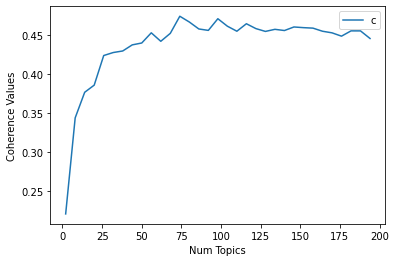

In [40]:
#graph
limit=200; start=2; step=6;
x=range(start,limit,step)
plt.plot(x, coherence_values_topic)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Values')
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
for n, cv in zip(x, coherence_values_topic):
    print("Num Topics =", n, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2207
Num Topics = 8  has Coherence Value of 0.3436
Num Topics = 14  has Coherence Value of 0.3764
Num Topics = 20  has Coherence Value of 0.3855
Num Topics = 26  has Coherence Value of 0.4234
Num Topics = 32  has Coherence Value of 0.4273
Num Topics = 38  has Coherence Value of 0.4293
Num Topics = 44  has Coherence Value of 0.4371
Num Topics = 50  has Coherence Value of 0.4395
Num Topics = 56  has Coherence Value of 0.4525
Num Topics = 62  has Coherence Value of 0.4417
Num Topics = 68  has Coherence Value of 0.4518
Num Topics = 74  has Coherence Value of 0.4737
Num Topics = 80  has Coherence Value of 0.4663
Num Topics = 86  has Coherence Value of 0.4574
Num Topics = 92  has Coherence Value of 0.4556
Num Topics = 98  has Coherence Value of 0.4706
Num Topics = 104  has Coherence Value of 0.461
Num Topics = 110  has Coherence Value of 0.4545
Num Topics = 116  has Coherence Value of 0.4641
Num Topics = 122  has Coherence Value of 0.4579
Num Topics =

In [42]:
optimal_model = model_topic_list[13]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(22,
  '0.116*"covid19" + 0.064*"coronavirus" + 0.037*"protest" + 0.029*"pandemic" '
  '+ 0.028*"costa" + 0.028*"identify" + 0.027*"rica" + 0.027*"podcast" + '
  '0.026*"resurgence" + 0.024*"houston"'),
 (33,
  '0.192*"united" + 0.061*"month" + 0.051*"flu" + 0.041*"dog" + '
  '0.034*"coronavirus" + 0.029*"states" + 0.027*"threat" + 0.026*"covid19" + '
  '0.025*"covid" + 0.021*"china"'),
 (55,
  '0.142*"case" + 0.098*"new" + 0.078*"coronavirus" + 0.077*"death" + '
  '0.070*"report" + 0.046*"covid19" + 0.043*"read" + 0.031*"record" + '
  '0.026*"total" + 0.022*"florida"'),
 (23,
  '0.130*"covid19" + 0.099*"pandemic" + 0.088*"coronavirus" + '
  '0.047*"comparison" + 0.037*"home" + 0.033*"covid" + 0.029*"work" + '
  '0.022*"misinformation" + 0.021*"test" + 0.019*"irans"'),
 (20,
  '0.177*"mask" + 0.113*"face" + 0.103*"wear" + 0.032*"enjoy" + 0.028*"major" '
  '+ 0.026*"protect" + 0.023*"reason" + 0.022*"facemask" + 0.021*"join" + '
  '0.020*"leave"'),
 (31,
  '0.057*"watch" + 0.047*"cure"

In [43]:
model_lda = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=74,
                       random_state=42,
                       chunksize=2000,
                       passes=25,
                       decay=0.5,
                       iterations=70)

In [44]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in model_lda.print_topics()]

In [45]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [46]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
2020 coronavirus july covid19 come brazil update join russia india

------ Topic 1 ------
wear mask covid19 simple common facial maskmt coronavirus link trial

------ Topic 2 ------
covid19 quarantine pandemic coronavirus app article deal effect half morning

------ Topic 3 ------
comparison covid19 treatment coronavirus surpass drug write cancel level low

------ Topic 4 ------
vietnam family company covid19 fun quarantine meaningful journa coronavirus montreal

------ Topic 5 ------
begin pandemic art artist photography san archive wait photographer hotel

------ Topic 6 ------
state expert sell fake california benefit area covid19coronaviru push geographical

------ Topic 7 ------
call continue early testing flu provide result free industry staff

------ Topic 8 ------
force accord leader lead friday covid19 coronavirus responder origin corporate

------ Topic 9 ------
look like summer see try social essential predict distancing mask

------ Topic 10 ------
thi

In [48]:
# Compute Perplexity
# a measure of how good the model is. lower the better
model_perplexity = model_lda.log_perplexity(corpus)
print('\nPerplexity: ', model_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=model_lda, texts=covid_data['lemmas_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.494793176177405

Coherence Score:  0.5168295066096583


In [50]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model_lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.213523 -0.028167       1        1  4.106392
39    -0.011075 -0.298571       2        1  3.785102
47    -0.012200 -0.360623       3        1  3.537024
33    -0.030377 -0.221003       4        1  2.735430
17    -0.044319 -0.019840       5        1  2.148833
...         ...       ...     ...      ...       ...
4      0.021277 -0.039453      70        1  0.827161
62     0.088596  0.068215      71        1  0.798395
46     0.135405  0.072167      72        1  0.790512
36     0.151482  0.004187      73        1  0.749132
30     0.038920  0.094756      74        1  0.747796

[74 rows x 5 columns], topic_info=             Term          Freq         Total Category  logprob  loglift
79           case   2948.000000   2948.000000  Default  30.0000  30.0000
11        covid19  14474.000000  14474.000000  Default  29.0000  29.0000
74          covid   2383.000000   2383.000000  Default  28.0000  28.0000
98            new   2316.000000   2316.000000  Default  27.0000  27.0000
2     coronavirus  13592.000000  13592.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
345          time     36.020031    528.531250  Topic74  -4.0344   2.2098
11        covid19     59.551517  14474.983398  Topic74  -3.5316  -0.5975
3325       sunday     22.816116    111.528893  Topic74  -4.4910   3.3090
610          free     25.589022    229.065247  Topic74  -4.3763   2.7040
1400         fact     18.802090    104.270325  Topic74  -4.6845   3.1828

[2805 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1710      37  0.989337     0000
10324     16  0.989727        1
1423      33  0.991557      100
244       59  0.991138     1000
3244       3  0.972611    10000
...      ...       ...      ...
3542       1  0.965419    youth
2466      59  0.966005  youtube
11476     71  0.899824      yyc
2501      53  0.960618     zero
1116      57  0.978179     zone

[2984 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 40, 48, 34, 18, 43, 21, 74, 69, 50, 70, 72, 3, 24, 8, 2, 30, 39, 25, 46, 51, 10, 68, 29, 32, 38, 52, 41, 35, 33, 6, 73, 44, 28, 20, 7, 57, 22, 67, 64, 15, 49, 27, 13, 45, 14, 16, 53, 54, 36, 62, 55, 42, 12, 4, 65, 11, 59, 71, 26, 9, 60, 58, 61, 23, 19, 17, 66, 56, 5, 63, 47, 37, 31])